# Import des packages

In [1]:
import pyvista as pv
import pandas as pd
import numpy as np
import pygmsh
import os

# Lecture des fichiers météorologiques

Ci-dessous vous trouverez une fonction permettant de lire le fichier epw à partir de son chemin.

In [4]:
def read_epw(path):
    nombre_lignes_en_tete=8
    columns=['Year', 'Month', 'Day', 'Hour', 'Minute', 'Data Source and Uncertaintly Flags',
    'Dry Bulb Temperature', 'Dew Point Temperature', 'Relative Humidity',
    'Atmospheric Station Pressure', 'Extraterrestrial Horizontal Radiation',
    'Extraterrestrial Direct Normal Radiation', 'Horizontal Infrared Radiation Intensity',
    'Global Horizontal Radiation',  'Direct Normal Radiation',  'Diffuse Horizontal Radiation',
    'Global Horizontal Illuminance', 'Direct Normal Illuminance', 'Diffuse Horizontal Illuminance',
    'Zenith Luminance', 'Wind Direction',   'Wind Speed',   'Total Sky Cover',
    'Opaque Sky Cover', 'Visibility',   'Ceiling Height',   'Present Weather Observation',
    'Present Weather Codes',    'Precipitable Water',   'Aerosol Optical Depth',
    'Snow Depth',   'Days Since Last Snowfall', 'Albedo',
    'Liquid Precipitation Depth',   'Liquid Precipitation Quantity']
    
    data_meteo=pd.read_csv(path, sep=",", skiprows = nombre_lignes_en_tete, header=None)
    data_meteo.columns=columns
    
    debut=str(data_meteo.iloc[0]['Year'])+'-'+str(data_meteo.iloc[0]['Month'])+'-'+str(data_meteo.iloc[0]['Day'])
    fin=str(data_meteo.iloc[-1]['Year'])+'-'+str(data_meteo.iloc[-1]['Month'])+'-'+str(data_meteo.iloc[-1]['Day'])
    
    hours_in_year=pd.date_range(debut, fin+' T23:00', freq='H')
    
    data_meteo.index=hours_in_year
    data_meteo=data_meteo.drop(['Data Source and Uncertaintly Flags'], axis=1)
    
    return data_meteo

In [5]:
chemin_meteo = r"D://ENS_PS-hour.epw"#remplir ici
data_meteo = read_epw(chemin_meteo)

Exercice:  
1- Tracer les évolutions de températures au cours de l'année  
2- Tracer la rose des vents

<Axes: >

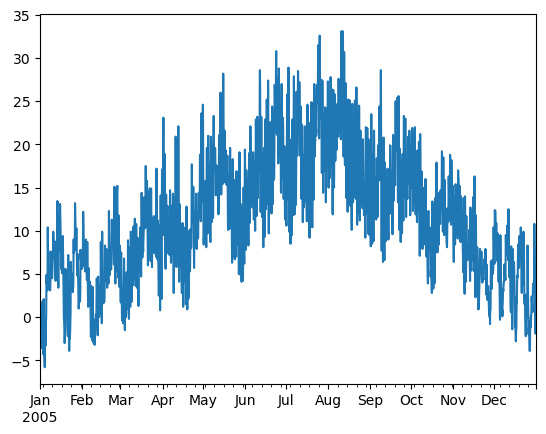

In [10]:
#Corrigé 1
data_meteo['Dry Bulb Temperature'].plot()

[Text(0.0, 0, 'E'),
 Text(0.7853981633974483, 0, 'N-E'),
 Text(1.5707963267948966, 0, 'N'),
 Text(2.356194490192345, 0, 'N-O'),
 Text(3.141592653589793, 0, 'O'),
 Text(3.9269908169872414, 0, 'S-O'),
 Text(4.71238898038469, 0, 'S'),
 Text(5.497787143782138, 0, 'S-E')]

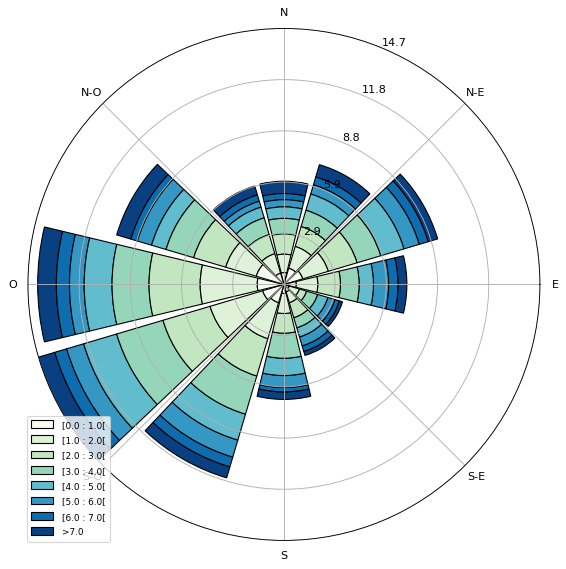

In [11]:
#Corrigé 2
from windrose import WindroseAxes
from windrose import WindAxes
import matplotlib.cm as cm

# stockage de ce qui nous intéresse
velocity=data_meteo['Wind Speed'].values
angle=data_meteo['Wind Direction'].values

#############################
# Solutions "out of the box", mais pas parfaite... 
# Construction Rose des vents
# 
ax = WindroseAxes.from_ax()
ax.bar(angle, velocity, normed=True, opening=0.9,nsector=12,bins=np.arange(0,8,1), edgecolor='k',cmap=cm.GnBu)
# ax.contourf(angle, air_vel, bins=np.arange(0, 8,1),nsectors=12, cmap=cm.hot)
ax.set_legend()
ax.set_xticklabels(['E', 'N-E', 'N', 'N-O', 'O', 'S-O', 'S', 'S-E'])

# Visualisation de la géométrie et de son environnement

In [15]:
#Lecture des géométries pour visualisation

env = pv.read("Cas1/geometries/env.stl")
bati = pv.read("Cas1/geometries/walls.stl")
fen = pv.read("Cas1/geometries/windows.stl")


In [17]:
# # long example
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(bati,"grey",label="batiment")
plotter.add_mesh(fen,"cyan",label="fenetres")
plotter.add_mesh(env,"orange",label="env")

plotter.add_legend()
plotter.show(jupyter_backend='trame')

#DEV:pour plus tard ajouter le nord

Widget(value='<iframe src="http://localhost:62737/index.html?ui=P_0x1adbabf5fc0_0&reconnect=auto" class="pyvis…

wslink is not expecting text message:
> 
wslink is not expecting text message:
> 
wslink is not expecting text message:
> 
wslink is not expecting text message:
> 


## Lancement d'un cas energyplus

Pour executer Energyplus en ligne de commande python, il suffit d'utiliser les lignes suivantes

In [20]:
from eppy import modeleditor
from eppy.modeleditor import IDF

iddfile=r"C:\EnergyPlusV9-4-0\Energy+.idd"

IDF.setiddname(iddfile)

adresse = r"D://"
fichier_epw = adresse+"ENS_PS-hour.epw"
input_file = "BE_ENS_vn_temp16.idf"
output_dir = adresse + input_file.replace(".idf","")
#%% lancer simulation d'origine
#help(IDF.run)
#idf_a_simuler = IDF(input_file,fichier_epw)
#idf_a_simuler.run(output_directory=output_dir)

## Analyse des résultats

<Axes: >

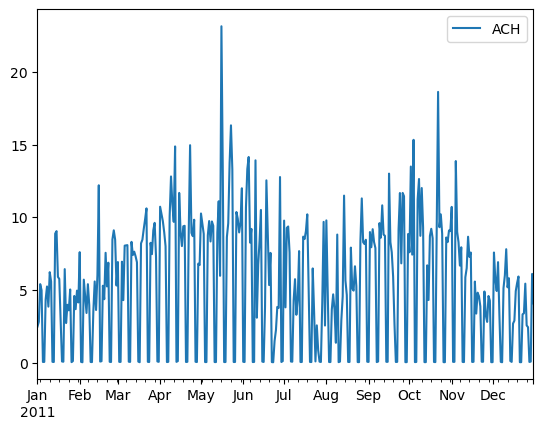

In [24]:
import esoreader
import matplotlib.pyplot as plt

tx_renouvel = pd.DataFrame(index=pd.date_range(start="01/01/2011", end="12/31/2011 23:00", freq="H"))

dd, data = esoreader.read(output_dir+"/"+"eplusout.eso")  
idx = dd.index[('Hourly','ATRIUM:ZONE1', 'AFN Zone Infiltration Air Change Rate')]
#La commande "dd.find_variable("Infiltration")" permet de repérer les sorties liées aux infiltrations.
#La liste des sorties est présente dans l'entête du fichier eplusout.eso

ts_atrium_temp = data[idx]
tx_renouvel["ACH"]=ts_atrium_temp

#heatmap - direction de vent vs vitesse
tx_renouvel.resample("D").mean().plot()

## Modifier un paramètre
voir https://eppy.readthedocs.io/en/latest/Main_Tutorial.html

## La ventilation naturelle dans DesignBuilder/EnergyPlus

pour en savoir plus: https://www.batisim.net/aide/index.html?temperatures_consignes_ventila.htm

Exercice: 

1- Lancer les simulations du batiment sans ventilation naturelle:
* version par défaut avec les cps
* version avec les cps obtenus de la CFD
   
2- Comparer les résultats (témpérature et taux de renouvellement d'air). Commenter?

In [31]:
#sans ventilation naturelle, différence

fichier_epw = "ENS_PS-hour.epw"

for file_simu in ["BE_ENS.idf","v1_36_dirs.idf"]:
    output_dir=file_simu.replace(".idf","")
    
    idf_a_simuler = IDF(file_simu,fichier_epw)
    idf_a_simuler.run(output_directory=output_dir)


C:\EnergyPlusV9-4-0\energyplus.exe --weather C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\ENS_PS-hour.epw --output-directory C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\BE_ENS --idd C:\EnergyPlusV9-4-0\Energy+.idd C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\BE_ENS_aaeaaa.idf


C:\EnergyPlusV9-4-0\energyplus.exe --weather C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\ENS_PS-hour.epw --output-directory C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\v1_36_dirs --idd C:\EnergyPlusV9-4-0\Energy+.idd C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\v1_36_dirs_f4a554.idf



In [51]:
liste_zone =['ATRIUM:ZONE1','RDC:ZONE1','RDC:ZONE2','NIVEAU1:ZONE1']

In [52]:
%matplotlib widget
tx_renouvel = pd.DataFrame(index=pd.date_range(start="01/01/2011", end="12/31/2011 23:00", freq="H"))

texte = ["STD avec Cp standard","STD avec Cp-CFD"]

for ii,file_simu in enumerate(["BE_ENS.idf","v1_36_dirs.idf"]):
    for zone in liste_zone:
        output_dir=file_simu.replace(".idf","")
        dd, data = esoreader.read(output_dir+"/eplusout.eso")
        indice = dd.index[('Hourly',zone, 'AFN Zone Infiltration Air Change Rate')]
        tx_renouvel["Air change rate "+texte[ii]+" "+zone] = data[indice]

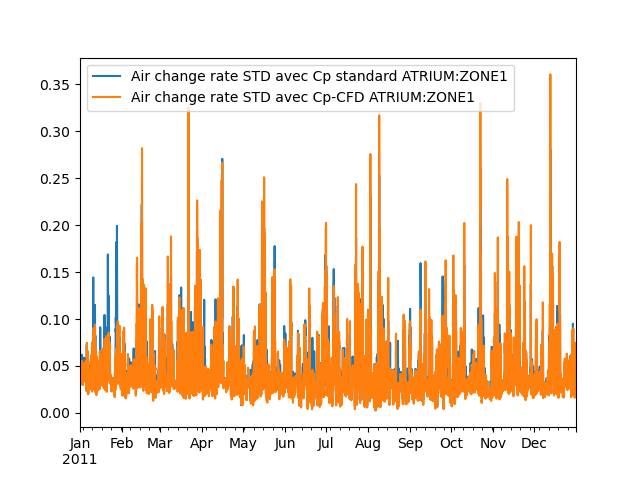

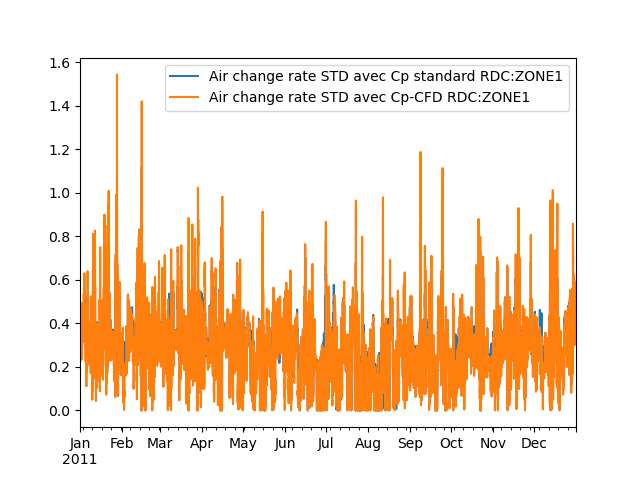

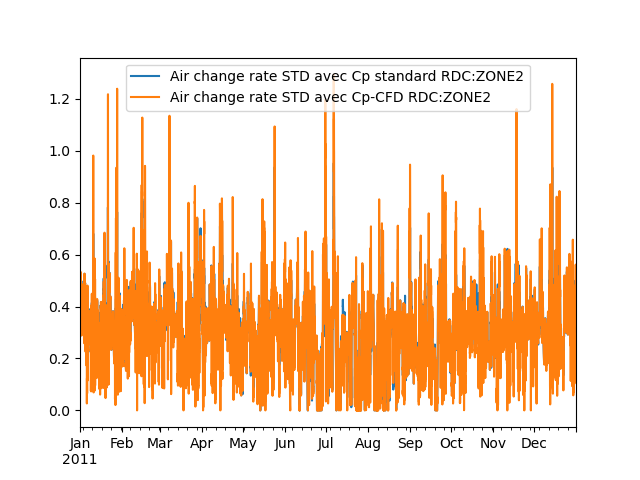

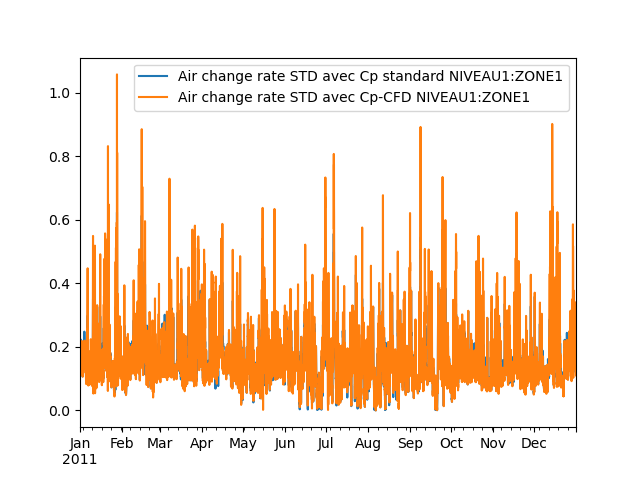

In [53]:
#TO DO: Améliorer l'esthétique des tracés
for zone in liste_zone:
    selected_column = list(tx_renouvel.columns[tx_renouvel.columns.str.contains(zone)])
    fig, ax = plt.subplots()
    tx_renouvel[selected_column].plot(ax=ax);

Exercice:
1- Faire de même avec de la ventilation naturelle. Pensez à appliquer:
-un planning
-une température de consigne
-une ouverture même légère aux ouvrants (on pourra considérer une ouverture similaire sur toutes les fenêtres)

2- Comparer les résultats en filtrant sur les périodes de ventilation naturelle

In [59]:
#avec ventilation naturelle, différence

for file_simu in ["BE_ENS_vn_temp16.idf","BE_ENS_vn_temp16_36_dirs.idf"]:
    output_dir=file_simu.replace(".idf","")
    
#    idf_a_simuler = IDF(file_simu,fichier_epw)
#    idf_a_simuler.run(output_directory=output_dir)

In [61]:
%matplotlib widget
tx_renouvel_vn = pd.DataFrame(index=pd.date_range(start="01/01/2011", end="12/31/2011 23:00", freq="H"))

texte = ["STD avec Cp standard","STD avec Cp-CFD"]

for ii,file_simu in enumerate(["BE_ENS_vn_temp16.idf","BE_ENS_vn_temp16_36_dirs.idf"]):
    for zone in liste_zone:
        output_dir=file_simu.replace(".idf","")
        dd, data = esoreader.read(output_dir+"/eplusout.eso")
        indice = dd.index[('Hourly',zone, 'AFN Zone Infiltration Air Change Rate')]
        tx_renouvel_vn["Air change rate "+texte[ii]+" "+zone] = data[indice]

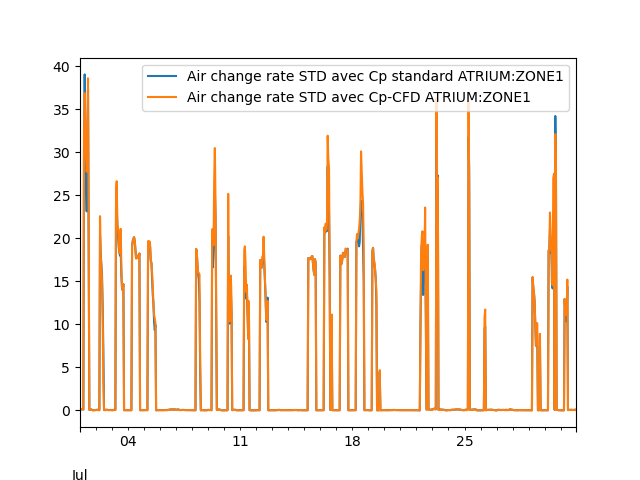

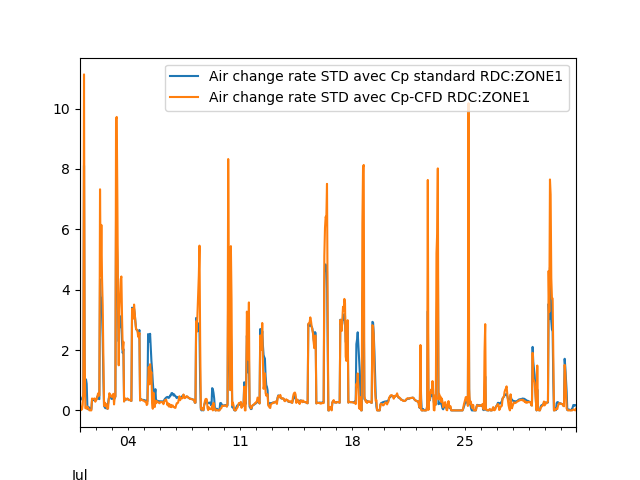

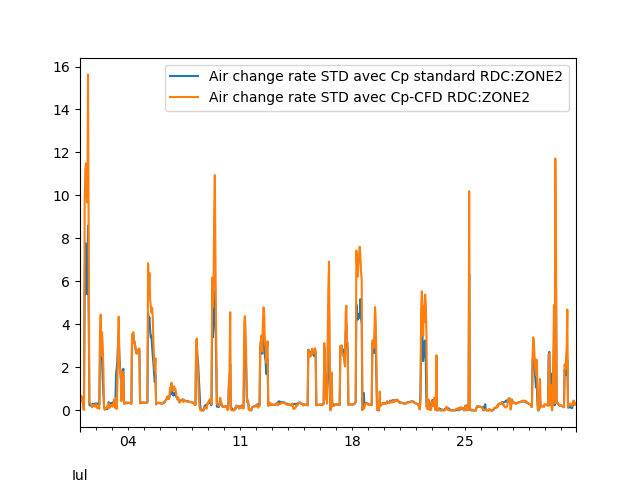

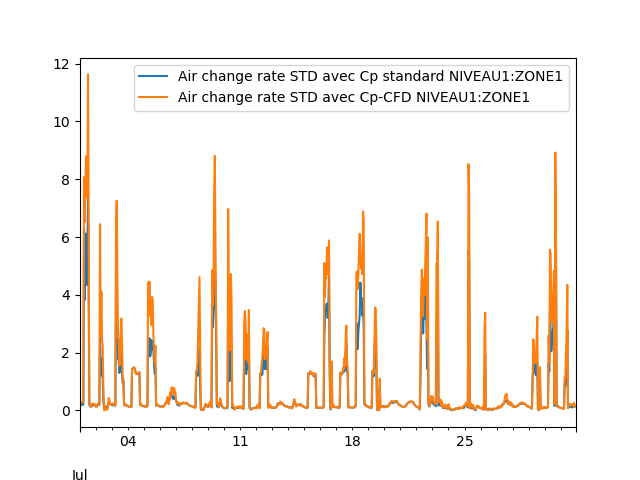

In [62]:
#TO DO: Améliorer l'esthétique des tracés
for zone in liste_zone:
    selected_column = list(tx_renouvel.columns[tx_renouvel.columns.str.contains(zone)])
    fig, ax = plt.subplots()
    tx_renouvel_vn[selected_column][tx_renouvel_vn.index.month==7].plot(ax=ax)

In [65]:
#avec ventilation naturelle, différence

for file_simu in ["BE_ENS_vn_temp16_tx_30.idf","v1_temp16_tx_30_36_dirs.idf"]:
    output_dir=file_simu.replace(".idf","")
    
    idf_a_simuler = IDF(file_simu,fichier_epw)
    idf_a_simuler.run(output_directory=output_dir)


C:\EnergyPlusV9-4-0\energyplus.exe --weather C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\ENS_PS-hour.epw --output-directory C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\BE_ENS_vn_temp16_tx_30 --idd C:\EnergyPlusV9-4-0\Energy+.idd C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\BE_ENS_vn_temp16_tx_30_623968.idf


C:\EnergyPlusV9-4-0\energyplus.exe --weather C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\ENS_PS-hour.epw --output-directory C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\v1_temp16_tx_30_36_dirs --idd C:\EnergyPlusV9-4-0\Energy+.idd C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\v1_temp16_tx_30_36_dirs_8b2abf.idf



In [66]:
tx_renouvel_vn = pd.DataFrame(index=pd.date_range(start="01/01/2011", end="12/31/2011 23:00", freq="H"))

texte = ["STD avec Cp standard","STD avec Cp-CFD"]

for ii,file_simu in enumerate(["BE_ENS_vn_temp16_tx_30.idf","v1_temp16_tx_30_36_dirs.idf"]):
    for zone in liste_zone:
        output_dir=file_simu.replace(".idf","")
        dd, data = esoreader.read(output_dir+"/eplusout.eso")
        indice = dd.index[('Hourly',zone, 'AFN Zone Infiltration Air Change Rate')]
        tx_renouvel_vn["Air change rate "+texte[ii]+" "+zone] = data[indice]

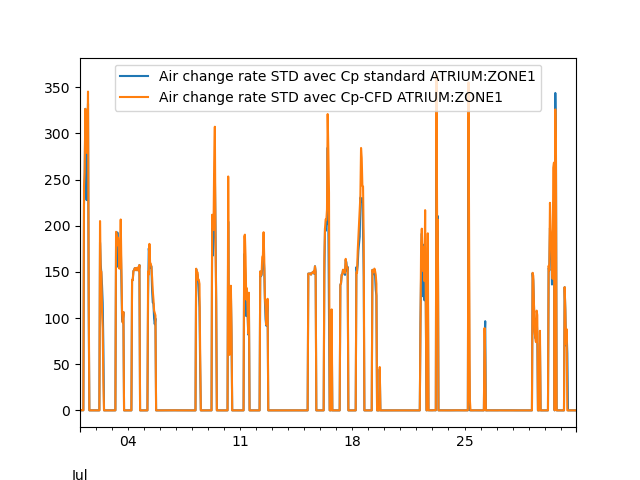

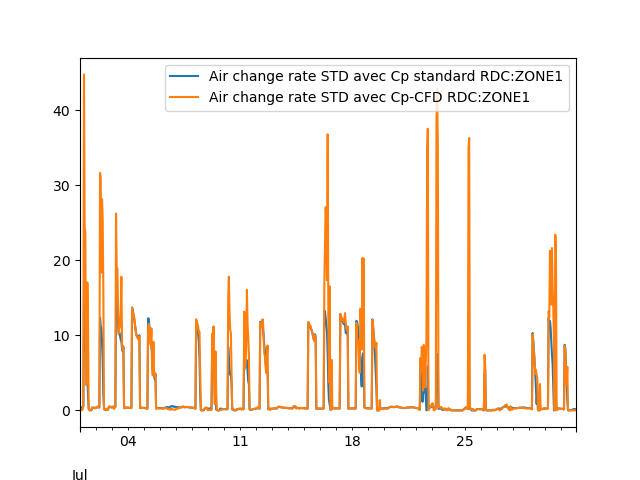

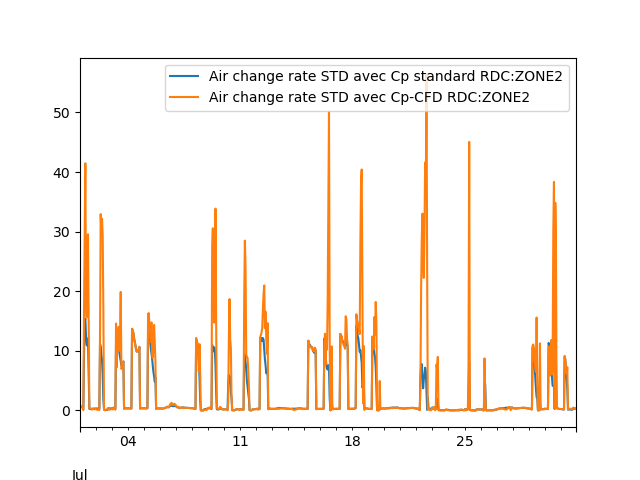

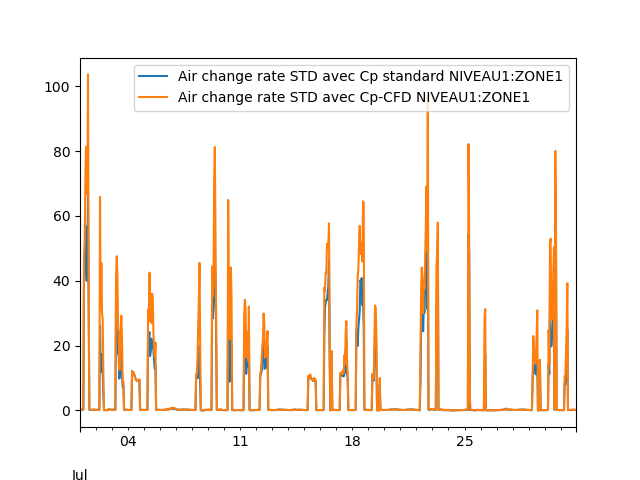

In [71]:
#TO DO: Améliorer l'esthétique des tracés
for zone in liste_zone:
    selected_column = list(tx_renouvel.columns[tx_renouvel.columns.str.contains(zone)])
    fig, ax = plt.subplots()
    tx_renouvel_vn[selected_column][tx_renouvel_vn.index.month==7].plot(ax=ax)

Quel est l'influence du nombre de directions discrétisées sur la prédiction? à partir du fichier à 36 directions réduire selon les diviseurs de 36 et conclure

In [135]:
def filter_wind_directions(nb_voulu,fichier_source):
    """Fonction pour redéfinir les fichiers pour un
    nombre de directions de vent différentes"""
    
    idf=IDF(fichier_source)
    print(nb_voulu)
    # nb_voulu = 4
    if 36 % nb_voulu!=0:
        sys.exit()
        
    indice_a_garder = []
    for elt in list(np.linspace(0,36,nb_voulu+1,dtype=int))[:-1]:
        indice_a_garder.append(elt)
    
    indice_a_filtrer = list(np.arange(0,36))
    
    for elt in indice_a_garder:
        indice_a_filtrer.remove(elt)
    
    les_directions=idf.idfobjects['AirflowNetwork:MultiZone:WindPressureCoefficientArray']
    les_Cps4 =idf.idfobjects['AirflowNetwork:MultiZone:WindPressureCoefficientValues']
    
    compteur = 0
    
    while compteur<len(indice_a_filtrer):
        les_directions.list2[0].pop(indice_a_filtrer[compteur]+2-compteur)
        for i in range(len(les_Cps4)):
            les_Cps4.list2[i].pop(indice_a_filtrer[compteur]+3-compteur)
        compteur+=1
    
    file_name = 'v1_36_dirs_'+str(nb_voulu)+'_directions.idf'
    idf.save(file_name)


for nb_voulu in [9,12,18,36]:
    
    filter_wind_directions(nb_voulu,"BE_ENS_vn_temp16_36_dirs.idf")
    
    file_name = 'v1_36_dirs_'+str(nb_voulu)+'_directions.idf'
    idf_a_simuler = IDF(file_name,fichier_epw)
    idf_a_simuler.run(output_directory=str(nb_voulu)+"_dir")

9

C:\EnergyPlusV9-4-0\energyplus.exe --weather C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\ENS_PS-hour.epw --output-directory C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\9_dir --idd C:\EnergyPlusV9-4-0\Energy+.idd C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\v1_36_dirs_9_directions_69a6f7.idf

12

C:\EnergyPlusV9-4-0\energyplus.exe --weather C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\ENS_PS-hour.epw --output-directory C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\12_dir --idd C:\EnergyPlusV9-4-0\Energy+.idd C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\v1_36_dirs_12_directions_e799a2.idf

18

C:\EnergyPlusV9-4-0\energyplus.exe --weather C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\ENS_PS-hour.epw --output-directory C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\18_dir --idd C:\EnergyPlusV9-4-0\Energy+.idd C:\Users\hubertan\Documents\BE Ventilation Naturelle\test\v1_36_dirs_18_direct

En réalisant une étude paramétrique sur le taux d'ouverture des fenêtres et la consigne de température, estimer comment est influencé le renouvellement d'air des différentes zones.

In [136]:
tx_renouvel_vn = pd.DataFrame(index=pd.date_range(start="01/01/2011", end="12/31/2011 23:00", freq="H"))

#Ktexte = ["STD avec Cp standard","STD avec Cp-CFD"]

for nb_voulu in [9,12,18,36]:
    for zone in liste_zone:
        output_dir=str(nb_voulu)+'_dir'
        dd, data = esoreader.read(output_dir+"/eplusout.eso")
        indice = dd.index[('Hourly',zone, 'AFN Zone Infiltration Air Change Rate')]
        tx_renouvel_vn["Air change rate "+str(nb_voulu)+"dir"+" "+zone] = data[indice]

C:\Users\hubertan\AppData\Local\Temp\ipykernel_11196\862372432.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


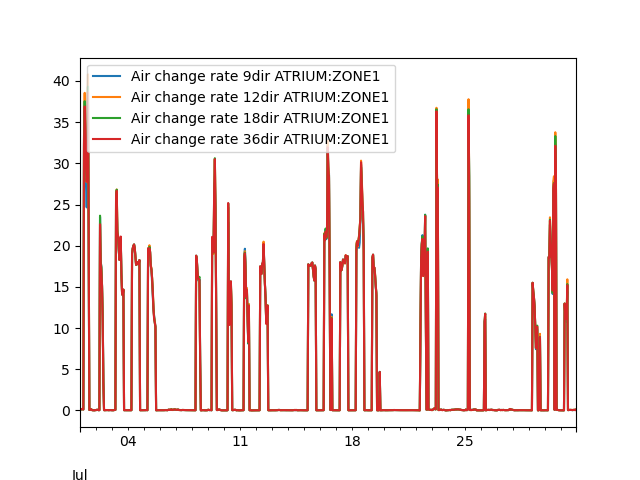

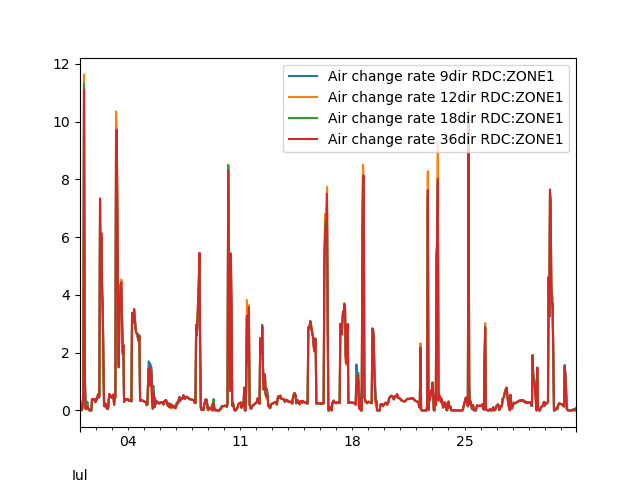

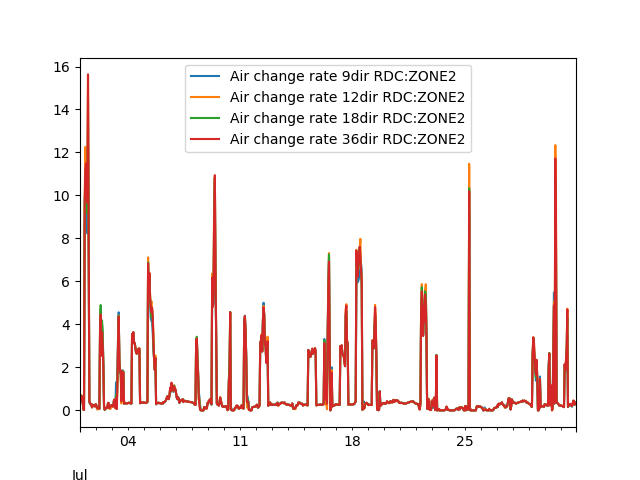

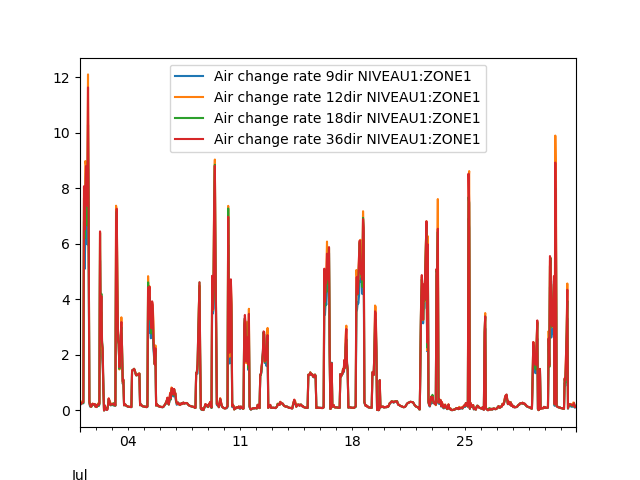

In [137]:
#TO DO: Améliorer l'esthétique des tracés
for zone in liste_zone:
    selected_column = list(tx_renouvel_vn.columns[tx_renouvel_vn.columns.str.contains(zone)])
    fig, ax = plt.subplots()
    tx_renouvel_vn[selected_column][tx_renouvel_vn.index.month==7].plot(ax=ax)

In [131]:
tx_renouvel_vn

,Air change rate 9dir ATRIUM:ZONE1,Air change rate 9dir RDC:ZONE1,Air change rate 9dir RDC:ZONE2,Air change rate 9dir NIVEAU1:ZONE1,Air change rate 12dir ATRIUM:ZONE1,Air change rate 12dir RDC:ZONE1,Air change rate 12dir RDC:ZONE2,Air change rate 12dir NIVEAU1:ZONE1,Air change rate 18dir ATRIUM:ZONE1,Air change rate 18dir RDC:ZONE1,Air change rate 18dir RDC:ZONE2,Air change rate 18dir NIVEAU1:ZONE1,Air change rate 36dir ATRIUM:ZONE1,Air change rate 36dir RDC:ZONE1,Air change rate 36dir RDC:ZONE2,Air change rate 36dir NIVEAU1:ZONE1
2011-01-01 00:00:00,0.035833,0.319427,0.358308,0.127229,0.037549,0.319228,0.356323,0.122765,0.038121,0.314645,0.350975,0.119584,0.038369,0.314817,0.351302,0.119188
2011-01-01 01:00:00,0.035774,0.321609,0.358040,0.124613,0.035792,0.320978,0.358577,0.125165,0.035651,0.323399,0.358092,0.126491,0.035953,0.321133,0.356792,0.123873
2011-01-01 02:00:00,0.034695,0.330738,0.357293,0.125097,0.034456,0.329755,0.358067,0.126457,0.034088,0.333244,0.358118,0.129266,0.034724,0.329627,0.355117,0.124139
2011-01-01 03:00:00,0.034155,0.333097,0.362586,0.128220,0.033535,0.331329,0.363932,0.131618,0.032979,0.338902,0.363005,0.136261,0.033064,0.336477,0.362745,0.135185
2011-01-01 04:00:00,0.033854,0.334262,0.363334,0.129310,0.033162,0.332308,0.364796,0.132985,0.032618,0.340255,0.363734,0.137571,0.032572,0.338071,0.364065,0.137359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31 19:00:00,0.047201,0.326838,0.442862,0.168562,0.048213,0.323353,0.442717,0.167552,0.047533,0.336617,0.433820,0.174642,0.048279,0.332897,0.431770,0.169871
2011-12-31 20:00:00,0.038229,0.380009,0.367635,0.156282,0.036319,0.380467,0.372854,0.154918,0.035618,0.383895,0.372986,0.159331,0.035889,0.385253,0.371696,0.157711
2011-12-31 21:00:00,0.033880,0.342550,0.353724,0.130163,0.032723,0.345661,0.356359,0.130682,0.032468,0.344532,0.356091,0.131384,0.032691,0.345647,0.356567,0.130791
2011-12-31 22:00:00,0.031523,0.325003,0.332361,0.115320,0.031971,0.324921,0.331715,0.114295,0.031769,0.324294,0.331189,0.114655,0.031948,0.324904,0.331843,0.114373


In [ ]:
liste_taux = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

tx_ouverture = 0.2
for tx_ouverture in liste_taux:
    idf=IDF(fname)
    # surface_ventilation = idf.idfobjects["AirflowNetwork:MultiZone:Surface"]
    # surface_ventilation_name=[k.Surface_Name for k in surface_ventilation if "Win" in k.Surface_Name if "Partition" not in k.Surface_Name]
    
    # Width factor for Opening factor #2 (dimensionless)
    # is_fenetres_outdoor
    fenetres_ouvertes=idf.idfobjects["AirflowNetwork:MultiZone:Component:DetailedOpening"]
    # fenetres_ouvertes=[k.Name for k in fenetres_ouvertes_bis if k.Name in surface_ventilation_name if k.Height_Factor_for_Opening_Factor_2>0.01]
    
    for fen in fenetres_ouvertes:
        fen.Height_Factor_for_Opening_Factor_2=tx_ouverture
        fen.Start_Height_Factor_for_Opening_Factor_2 = 1-tx_ouverture
        
        
        idf.saveas("idf"+str(tx_ouverture)+".idf")
    
    
for tx_ouverture in liste_taux:
    idf_sortie="idf"+str(tx_ouverture)+".idf"
    idf_a_simuler = IDF(idf_sortie,fichier_epw)
    idf_a_simuler.run(output_directory="idf"+str(tx_ouverture))
    
    
#%%


liste_taux = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

# tx_ouverture = 0.2

df = pd.DataFrame(index=pd.date_range(start="01/01/2011", end="12/31/2011 23:00", freq="H"))

for tx_ouverture in liste_taux:
    idf=IDF(fname)
    # surface_ventilation = idf.idfobjects["AirflowNetwork:MultiZone:Surface"]


    dd, data = esoreader.read("idf"+str(tx_ouverture)+"/eplusout.eso")    
    idx = dd.index[('Hourly','BLOC1:ZONE1', 'Zone Air System Sensible Cooling Rate')]
        
    ts_indoor_temp = data[idx]
    df["idf"+str(tx_ouverture)]=ts_indoor_temp

Repérer quelle condition de vent génère le plus d'écart? quelle condition de vent génère le plus de renouvellement?

In [194]:
fenetres_ouvertes=idf.idfobjects["AirflowNetwork:MultiZone:Component:DetailedOpening"]

NameError: name 'idf' is not defined

In [ ]:
#tracé la rose des débits?

In [ ]:
#evaluer l'influence pour 36 directions, =2*3*2*3 = 1 2 3 4 6 9 12 18 36

In [ ]:
#faire varier la température de consigne
#faire varier le taux d'ouverture des ouvrants
#mettre un planning de nuit

et la température dans tout ça?